In [27]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import numpy as np
from sklearn.utils import class_weight
import os.path

In [28]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(256, 256, 3))

In [31]:
# dimensions of our images.
img_width, img_height = 256, 256

top_layers_checkpoint_path = 'weights/InceptionV3/cp.top.best.hdf5'
fine_tuned_checkpoint_path = 'weights/InceptionV3/cp.fine_tuned.best.hdf5'
new_extended_inception_weights = 'weights/InceptionV3/final_weights.hdf5'

train_batchsize = 32
val_batchsize = 32

train_data_dir = 'data/train'
validation_data_dir = 'data/val'

In [32]:
from keras.preprocessing.image import ImageDataGenerator

In [33]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [34]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=train_batchsize,
        class_mode='categorical',
        color_mode="rgb",
        shuffle=True
)

Found 48855 images belonging to 38 classes.


In [35]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=val_batchsize,
        class_mode='categorical',
        color_mode="rgb",
        shuffle=False
)

Found 5447 images belonging to 38 classes.


In [36]:
nb_train_samples = 48855
nb_validation_samples =  5447

batch_size = 32

In [37]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(38, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [38]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [39]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=['accuracy'])

In [40]:
#Save the model after every epoch.
mc_top = ModelCheckpoint(top_layers_checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
import time
#Save the TensorBoard logs. histogram_freq was 1 (gave errors) and now is 0. write_images was True (read that this is heavy) and now is False
name="Inceptionv3-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir="logs/{}".format(name))

In [14]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[mc_top, tensorboard],
    verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1954/1954 [==============================] - 1765s 903ms/step - loss: 0.6639 - acc: 0.8060 - val_loss: 3.0790 - val_acc: 0.4696
Epoch 2/10
1954/1954 [==============================] - 843s 431ms/step - loss: 0.3458 - acc: 0.8923 - val_loss: 5.1770 - val_acc: 0.2484
Epoch 3/10
1954/1954 [==============================] - 773s 395ms/step - loss: 0.3063 - acc: 0.9077 - val_loss: 3.3981 - val_acc: 0.4661
Epoch 4/10
1954/1954 [==============================] - 664s 340ms/step - loss: 0.2692 - acc: 0.9193 - val_loss: 4.4841 - val_acc: 0.4207
Epoch 5/10
1954/1954 [==============================] - 666s 341ms/step - loss: 0.2538 - acc: 0.9264 - val_loss: 4.1016 - val_acc: 0.3972
Epoch 6/10
1954/1954 [==============================] - 665s 340ms/step - loss: 0.2441 - acc: 0.9306 - val_loss: 4.5292 - val_acc: 0.4887
Epoch 7/10
1954/1954 [==============================] - 663s 339ms/step - loss: 0.2300 - acc: 0.9356 - val_loss: 6.7261 - v

In [16]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [17]:
#Save the model after every epoch.
mc_fit = ModelCheckpoint(fine_tuned_checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [18]:
if os.path.exists(fine_tuned_checkpoint_path):
    model.load_weights(fine_tuned_checkpoint_path)
    print ("Checkpoint '" + fine_tuned_checkpoint_path + "' loaded.")

In [19]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
# in other examples found it was 172 insted 249. 
# I took 249 according to https://keras.io/applications/#inceptionv3
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [20]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss="categorical_crossentropy", metrics=['accuracy'])

In [21]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[mc_fit, tensorboard],
    verbose=1)

Epoch 1/20
1954/1954 [==============================] - 672s 344ms/step - loss: 0.1038 - acc: 0.9696 - val_loss: 3.3670 - val_acc: 0.6175
Epoch 2/20
1954/1954 [==============================] - 664s 340ms/step - loss: 0.0507 - acc: 0.9830 - val_loss: 5.1044 - val_acc: 0.3747
Epoch 3/20
1954/1954 [==============================] - 651s 333ms/step - loss: 0.0383 - acc: 0.9880 - val_loss: 2.7575 - val_acc: 0.6470
Epoch 4/20
1954/1954 [==============================] - 645s 330ms/step - loss: 0.0312 - acc: 0.9899 - val_loss: 3.8401 - val_acc: 0.5336
Epoch 5/20
1954/1954 [==============================] - 647s 331ms/step - loss: 0.0248 - acc: 0.9922 - val_loss: 3.2424 - val_acc: 0.5733
Epoch 6/20
1954/1954 [==============================] - 655s 335ms/step - loss: 0.0220 - acc: 0.9928 - val_loss: 3.1837 - val_acc: 0.6276
Epoch 7/20
1954/1954 [==============================] - 674s 345ms/step - loss: 0.0179 - acc: 0.9942 - val_loss: 5.1242 - val_acc: 0.3926
Epoch 8/20
1954/1954 [============

In [22]:
import PIL
import time

In [23]:
# serialize model to JSON
model_json = model.to_json()
with open("weights/InceptionV3/InceptionV3_model.json", "w") as json_file:
    json_file.write(model_json)

In [24]:
model.save_weights(new_extended_inception_weights)

In [41]:
# load json and create model
from keras.models import model_from_json
json_file = open('weights/InceptionV3/InceptionV3_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("weights/InceptionV3/final_weights.hdf5")
print("Loaded model from disk")

FileNotFoundError: [Errno 2] No such file or directory: 'weights/InceptionV3/InceptionV3_model.json'

In [3]:
loaded_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [4]:
import cv2
from tqdm import tqdm
import itertools
import numpy as np
import matplotlib.pyplot as plt
import json

In [20]:
im = cv2.imread("test images/tomato_healthy.jpg")

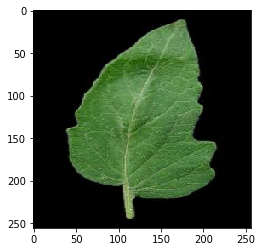

In [21]:
im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256))
plt.imshow(im)
im = np.expand_dims(im, axis =0)

In [22]:
outcome=loaded_model.predict(im)

In [23]:
with open('labels.json', 'r') as fp:
    data = json.load(fp)

In [24]:
data[str(np.argmax(outcome))]

'Blueberry___healthy'

### let us visually see the errors that we got.

In [ ]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        "data/val",
        target_size=(256, 256),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1) 


In [ ]:
import numpy as np
import PIL 
from keras.preprocessing import image

In [ ]:
predicted_classes = np.argmax(predictions,axis=1)
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = image.load_img('{}/{}'.format("data/val",fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()